In [13]:
import numpy as np, math
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)
rng = np.random.default_rng(7)  # фиксируем сид


In [14]:
''' Возьмем простые данные - n-мерное изотропное нормальное распределение N(0, I_d) '''

import numpy as np

def logp(x):
    x = np.asarray(x)
    return -0.5 * np.dot(x, x)   # скаляр

def grad_logp(x):
    x = np.asarray(x)
    return -x

# мой второй пример данных: вернем имя + (logp, grad_logp)
def your_data_utils():
    """Пример "крученой" цели (banana, 2D). Можно переименовать на что угодно."""
    a, b = 1.0, 0.1
    def logp2(x):
        x = np.asarray(x)
        x1, x2 = x[0], x[1]
        U = (a - x1)**2 + 100.0 * (x2 - x1**2)**2
        return -0.5 * b * U      # скаляр
    def grad_logp2(x):
        x = np.asarray(x)
        x1, x2 = x[0], x[1]
        dU_dx1 = -2*(a - x1) - 400*x1*(x2 - x1**2)
        dU_dx2 = 200*(x2 - x1**2)
        return -0.5 * b * np.array([dU_dx1, dU_dx2])
    return "my_curved_target", logp2, grad_logp2 


In [15]:
''' Посчитаем ESS через интегрированную автокорреляции '''

def ess(x, K=50):
    """
    Эффективный размер выборки по интегрированной автокорреляции.
    Возвращает вектор ESS по измерениям (если x многомерный).
    Если нужен один скаляр, возьми .mean().
    """
    x = np.asarray(x)
    if x.ndim == 1:
        x = x[:, None]
    n, d = x.shape
    out = []
    for j in range(d):
        xs = x[:, j] - x[:, j].mean()
        var = (xs @ xs) / n
        if var == 0:
            out.append(float(n))
            continue
        s = 0.0
        # суммируем пока положительно
        for k in range(1, min(K, n-1) + 1):
            rho = (xs[:-k] @ xs[k:]) / ((n - k) * var)
            if rho < 0:
                break
            s += rho
        tau = 1 + 2 * s
        out.append(n / tau if tau > 0 else n)
    return np.array(out)


In [16]:
''' Базовая реализация MH алгоритма '''

def mh(logpi, x0, steps, scale, rng=rng):
    x = x0.copy()
    d = len(x)
    chain = np.zeros((steps, d))
    accept = 0
    for t in range(steps):
        prop = x + rng.normal(0, scale, size=d)
        if np.log(rng.uniform()) < (float(logpi(prop)) - float(logpi(x))):
            x = prop
            accept += 1
        chain[t] = x
    return chain, accept / steps


In [17]:
# Тут нужно заимплементить Metropolis Adjusted Langevin Algorithm (MALA)

# MALA: x' = x + h ∇logπ(x) + √(2h) z, с MH-коррекцией асимметрии

def mala(logpi, grad_logpi, x0, step, n_samples, rng=rng):
    """
    logpi: функция, возвращающая СКАЛЯР log π(x)
    grad_logpi: градиент (вектор длины d)
    x0: старт (shape (d,))
    step: шаг Ланжевена h
    n_samples: длина цепи
    """
    d = len(x0)
    x = np.array(x0, dtype=float)
    samples = np.empty((n_samples, d))
    acc = 0
    step = float(step)
    sqrt2step = math.sqrt(2*step)

    # текущее значение лога и градиента
    lp_x = float(logpi(x))
    g_x  = grad_logpi(x)

    # лог-плотность предложения
    def log_q(x_to, x_from, g_from):
        diff = x_to - (x_from + step * g_from)
        return -0.25/step * (diff @ diff)  # + const

    for t in range(n_samples):
        mean   = x + step * g_x
        noise  = rng.standard_normal(d)
        x_prop = mean + sqrt2step * noise

        lp_prop = float(logpi(x_prop))
        g_prop  = grad_logpi(x_prop)

    # MH-приёмка с учётом асимметрии q
        log_alpha = (lp_prop + log_q(x, x_prop, g_prop)) - (lp_x + log_q(x_prop, x, g_x))
        if np.log(rng.random()) < log_alpha:
            x, lp_x, g_x = x_prop, lp_prop, g_prop
            acc += 1

        samples[t] = x

    return samples, acc / n_samples


MH accept=0.259 | median ESS=824.6
MALA accept=0.697 | median ESS=6381.4


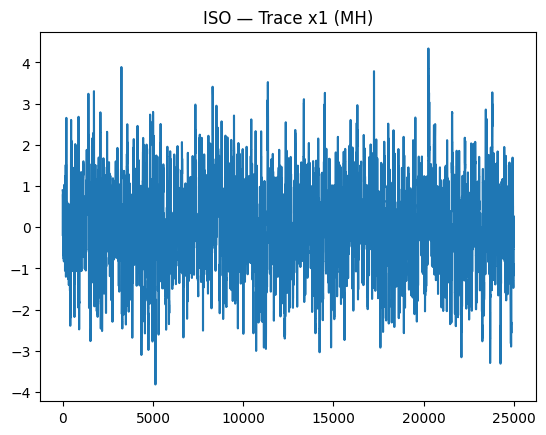

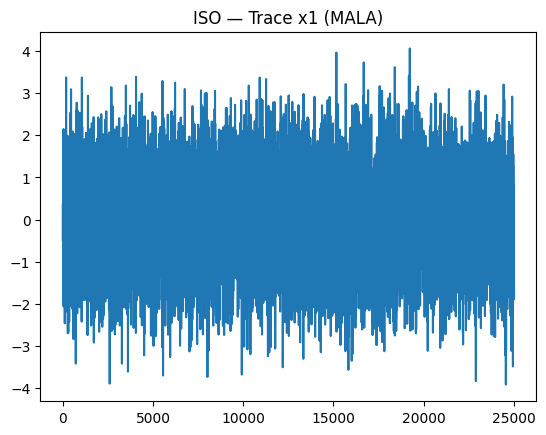


Вывод (ISO): MALA эффективнее (ESS≈6381 vs 825); принятие 0.70 vs 0.26.


In [18]:
d = 10
steps = 30000
burn = 5000
x0 = np.ones(d) * 3 # стартанев в точке 3 например

mala_step = 0.5 # тут попробуйте подобрать хороший шаг
mh_scale = 2.4 / np.sqrt(d) # тут попробуйте подобрать скейл для пропозала в MH. Может какие-то варианты будут лучше MALA?

mala_core = mala  # сохраним «настоящую» MALA из ячейки 5
def mala(x0, steps, step, rng=rng):
    return mala_core(logp, grad_logp, x0, step, steps, rng=rng)

mh_chain, mh_acc = mh(logp, x0, steps, scale=mh_scale)
mala_chain, mala_acc = mala(x0, steps, step=mala_step)

# Выведите снизу acceptance rate и медианный ESS по размерности d для MH и MALA. Не забудьте обрезать burn-in!
# подсчёт метрик c burn-in и медианным ESS по d
def ess_vec(samples):
    samples_b = samples[burn:]
    # если ess(x) 1D — считаем по каждой координате
    return np.array([ess(samples_b[:, j]) for j in range(samples_b.shape[1])])

mh_ess_med   = np.median(ess_vec(mh_chain))
mala_ess_med = np.median(ess_vec(mala_chain))

print(f"MH accept={mh_acc:.3f} | median ESS={mh_ess_med:.1f}")
print(f"MALA accept={mala_acc:.3f} | median ESS={mala_ess_med:.1f}")

# графики
plt.figure(); plt.plot(mh_chain[burn:,0]); plt.title("ISO — Trace x1 (MH)"); plt.show()
plt.figure(); plt.plot(mala_chain[burn:,0]); plt.title("ISO — Trace x1 (MALA)"); plt.show()

# краткий вывод по ISO (2 предложения)
print("\nВывод (ISO):",
      "MALA эффективнее" if mala_ess_med > mh_ess_med else "MH эффективнее",
      f"(ESS≈{mala_ess_med:.0f} vs {mh_ess_med:.0f}); принятие {mala_acc:.2f} vs {mh_acc:.2f}.")

In [20]:
nameB, logp2, grad_logp2 = your_data_utils()

# параметры для второго набора
x0_B = np.array([0.0, 0.0]) # старт
steps_B = steps # столько же итераций, как для ISO
burn_B = burn
mh_scale_B = 0.28
mala_step_B = 0.03

# обёртки под тот же интерфейс
def mh2(x0, steps, scale, rng=rng):
    # моя mh уже принимает logpi первым аргументом
    return mh(logp2, x0, steps, scale, rng=rng)

def mala2(x0, steps, step, rng=rng):
    return mala_core(logp2, grad_logp2, x0, step, steps, rng=rng)

# запуск
mh_chain_B,   mh_acc_B   = mh2(x0_B, steps_B, scale=mh_scale_B)
mala_chain_B, mala_acc_B = mala2(x0_B, steps_B, step=mala_step_B)

# метрики (медианный ESS по координатам) аналогично ISO
def ess_vec_b(samples):
    sb = samples[burn_B:]
    return np.array([ess(sb[:, j]) for j in range(sb.shape[1])])

mh_ess_med_B   = np.median(ess_vec_b(mh_chain_B))
mala_ess_med_B = np.median(ess_vec_b(mala_chain_B))

print(f"[{nameB}] accept: MH={mh_acc_B:.3f} | MALA={mala_acc_B:.3f}")
print(f"[{nameB}] median ESS: MH={mh_ess_med_B:.1f} | MALA={mala_ess_med_B:.1f}")


[my_curved_target] accept: MH=0.460 | MALA=0.516
[my_curved_target] median ESS: MH=266.6 | MALA=266.2


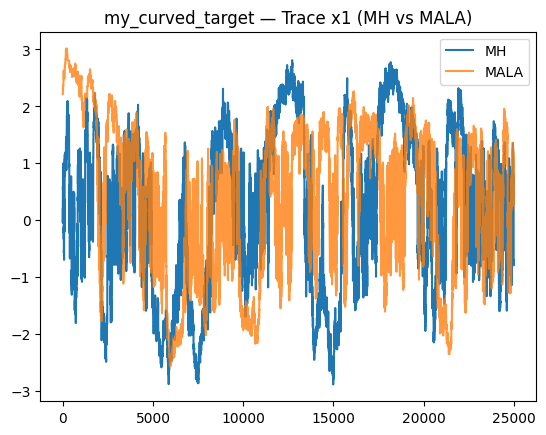

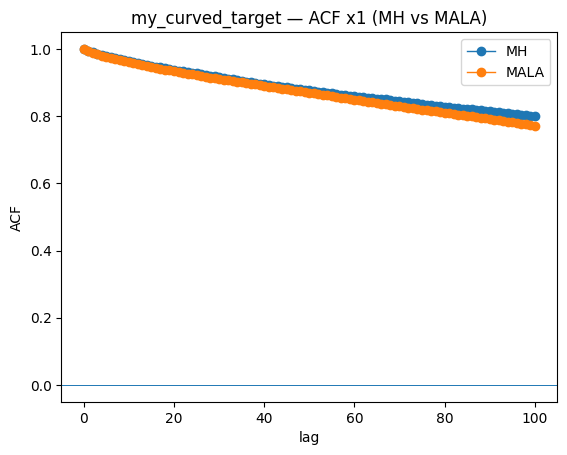

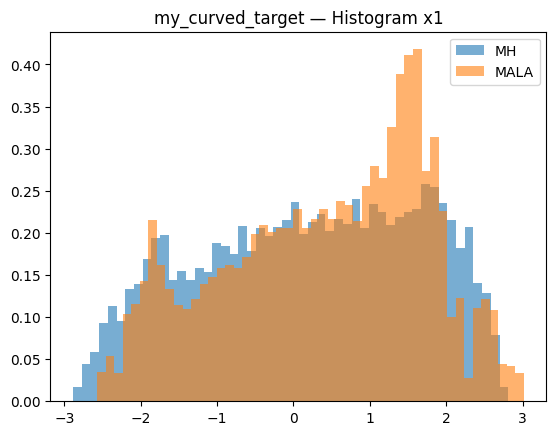


Вывод: MH эффективнее (ESS≈266 vs 267); принятие 0.52 vs 0.46.


In [22]:
# Здесь нарисуйте 3 графика: trace plot (значение цепи vs итерация),
# график автокорреляции (значение ACF vs задержка по времени) и гистограмма семплов (возьмите какую-то одну размерность)

import matplotlib.pyplot as plt
import numpy as np

def acf_1d(x, max_lag=100):
    x = np.asarray(x, float)
    x = x - x.mean()
    n = len(x)
    if n < 2:
        return np.array([1.0])
    var = (x @ x) / n
    r = [1.0]
    for k in range(1, min(max_lag, n-1)+1):
        r.append((x[:-k] @ x[k:]) / ((n-k)*var))
    return np.array(r)


mh_x1_B   = mh_chain_B[burn_B:, 0]
mala_x1_B = mala_chain_B[burn_B:, 0]

# trace plot
plt.figure()
plt.plot(mh_x1_B, label="MH")
plt.plot(mala_x1_B, label="MALA", alpha=0.8)
plt.title(f"{nameB} — Trace x1 (MH vs MALA)")
plt.legend(); plt.show()

# 2) ACF
acf_mh   = acf_1d(mh_x1_B,   max_lag=100)
acf_mala = acf_1d(mala_x1_B, max_lag=100)

lags = np.arange(len(acf_mh))

plt.figure()
plt.plot(lags, acf_mh,  marker='o', linewidth=1, label="MH")
plt.plot(lags, acf_mala, marker='o', linewidth=1, label="MALA")
plt.axhline(0.0, linewidth=0.7)
plt.title(f"{nameB} — ACF x1 (MH vs MALA)")
plt.xlabel("lag"); plt.ylabel("ACF")
plt.legend(); plt.show()

# 3) гистограмма
plt.figure()
plt.hist(mh_x1_B, bins=50, density=True, alpha=0.6, label="MH")
plt.hist(mala_x1_B, bins=50, density=True, alpha=0.6, label="MALA")
plt.title(f"{nameB} — Histogram x1")
plt.legend(); plt.show()

print("\nВывод:",
      ("MALA эффективнее" if mala_ess_med_B > mh_ess_med_B else "MH эффективнее"),
      f"(ESS≈{mala_ess_med_B:.0f} vs {mh_ess_med_B:.0f}); "
      f"принятие {mala_acc_B:.2f} vs {mh_acc_B:.2f}.")

